In [1]:
from typing import Any

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import treescope
from penzai import pz

from simplexity.generative_processes.hidden_markov_model import HiddenMarkovModel
from simplexity.generative_processes.transition_matrices import mess3
from simplexity.predictive_models.rnn import RNN
from simplexity.training.train import train

In [2]:
treescope.basic_interactive_setup(autovisualize_arrays=True)

In [3]:
key = jax.random.PRNGKey(0)

transition_matrices = mess3()
vocab_size = int(transition_matrices.shape[0])
generative_process = HiddenMarkovModel(transition_matrices)
initial_gen_process_state = generative_process.state_eigenvector

hidden_size = 64
hidden_sizes = [hidden_size] * 4
key, model_key = jax.random.split(key)
model = RNN(in_size=vocab_size, out_size=vocab_size, hidden_sizes=hidden_sizes, key=model_key)
optimizer = optax.adam(learning_rate=0.001)

sequence_len = 64
batch_size = 128
num_epochs = 1000

In [4]:
model, losses = train(
    key,
    model,
    optimizer,
    generative_process,
    initial_gen_process_state,
    num_epochs,
    batch_size,
    sequence_len,
    log_every=1,
)

[<matplotlib.lines.Line2D at 0x7f61b01e0410>]

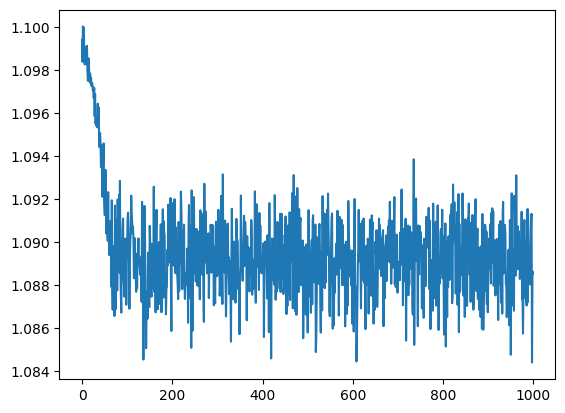

In [5]:
plt.plot(losses)

In [6]:
@pz.pytree_dataclass
class SaveActivations(pz.nn.Layer):
    saved_activations: pz.StateVariable[list[Any]]

    def __call__(self, activations: Any, **unused_side_inputs) -> Any:
        self.saved_activations.value = self.saved_activations.value + [activations]
        return activations

In [7]:
saved_activations = pz.StateVariable(value=[], label="activations")

saving_model = pz.select(model).at_instances_of(eqx.nn.Lambda).insert_after(SaveActivations(saved_activations))

saving_model

RNN(
  in_size=3,
  out_size=3,
  layers=Sequential(
    layers=(
      Lambda(
        fn=GRUFn(
          cell=GRUCell(
            weight_ih=f32[192,3],
            weight_hh=f32[192,64],
            bias=f32[192],
            bias_n=f32[64],
            input_size=3,
            hidden_size=64,
            use_bias=True
          )
        )
      ),
      SaveActivations(
        saved_activations=StateVariable(label='activations', value=[], metadata={})
      ),
      Lambda(
        fn=GRUFn(
          cell=GRUCell(
            weight_ih=f32[192,64],
            weight_hh=f32[192,64],
            bias=f32[192],
            bias_n=f32[64],
            input_size=64,
            hidden_size=64,
            use_bias=True
          )
        )
      ),
      SaveActivations(
        saved_activations=StateVariable(label='activations', value=[], metadata={})
      ),
      Lambda(
        fn=GRUFn(
          cell=GRUCell(
            weight_ih=f32[192,64],
            weight_hh=f32[192,64],
            bias=f32[192],
            bias_n=f32[64],
            input_size=64,
            hidden_size=64,
            use_bias=True
          )
        )
      ),
      SaveActivations(
        saved_activations=StateVariable(label='activations', value=[], metadata={})
      ),
      Lambda(
        fn=GRUFn(
          cell=GRUCell(
            weight_ih=f32[192,64],
            weight_hh=f32[192,64],
            bias=f32[192],
            bias_n=f32[64],
            input_size=64,
            hidden_size=64,
            use_bias=True
          )
        )
      ),
      SaveActivations(
        saved_activations=StateVariable(label='activations', value=[], metadata={})
      ),
      Lambda(
        fn=LinearFn(
          linear=Linear(
            weight=f32[3,64],
            bias=f32[3],
            in_features=64,
            out_features=3,
            use_bias=True
          )
        )
      ),
      SaveActivations(
        saved_activations=StateVariable(label='activations', value=[], metadata={})
      )
    )
  )
)

In [8]:
gen_process_states = jnp.repeat(initial_gen_process_state[None, :], batch_size, axis=0)
batch_keys = jax.random.split(key, batch_size)
_, obs = generative_process.generate(gen_process_states, batch_keys, sequence_len)
pz.nx.wrap(obs, "batch", "sequence")

<NamedArray int32(| batch:128, sequence:64) [≥0, ≤2] zero:2_816 nonzero:5_376 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

In [9]:
x = jax.nn.one_hot(obs, vocab_size)
pz.nx.wrap(x, "batch", "sequence", "vocab")

<NamedArray float32(| batch:128, sequence:64, vocab:3) ≈0.33 ±0.47 [≥0.0, ≤1.0] zero:16_384 nonzero:8_192 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

In [10]:
logits = eqx.filter_vmap(saving_model)(x)
probs = jax.nn.softmax(logits, axis=-1)
pz.nx.wrap(probs, "batch", "sequence", "vocab")

<NamedArray float32(| batch:128, sequence:64, vocab:3) ≈0.33 ±0.013 [≥0.32, ≤0.35] nonzero:24_576 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

In [11]:
saved_activations = saved_activations.__class__(
    value=[value.val for value in saved_activations.value],  # Convert batch traced array to regular array
    label=saved_activations.label,
    metadata=saved_activations.metadata,
)

saved_activations

StateVariable(label='activations', value=[<jax.Array float32(64, 128, 64) ≈-0.0013 ±0.1 [≥-0.25, ≤0.35] nonzero:524_288>, <jax.Array float32(64, 128, 64) ≈-0.0066 ±0.11 [≥-0.34, ≤0.23] nonzero:524_288>, <jax.Array float32(64, 128, 64) ≈0.0041 ±0.11 [≥-0.29, ≤0.24] nonzero:524_288>, <jax.Array float32(64, 128, 64) ≈-0.015 ±0.1 [≥-0.24, ≤0.26] nonzero:524_288>, <jax.Array float32(64, 128, 3) ≈0.048 ±0.038 [≥-0.0004, ≤0.1] nonzero:24_576>], metadata={})